# Assignment03

#### Student no : 21626934
#### Student name : Edib Hamza Arslan



First of all I will initialize pyspark 3.1.1

In [ ]:
# https://downloads.apache.org/spark/
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark

Set up enviroment paths.

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

Create spark session.

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Import libraries.

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.simplefilter('ignore')
%matplotlib inline

from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Clustring
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array
import pyspark.sql.functions as F


## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>

Describe the aim of this assigment here. What are the questions you are trying to solve?
* In this assignment, our aim is classified the bean types. There are totaly 7 different type. The dataset has 17 columns. We try to solve predict right bean which given features. 
We are going to use pyspark machine learning libraries for that.

## Data Understanding<a class="anchor" id="data_understanding"></a>

Reading csv data

In [5]:
data_path = 'Data/data.csv'
raw_data = spark.read.csv(data_path, inferSchema=True, header =True)

In [6]:
raw_data.printSchema()

root
 |-- Area: integer (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- MajorAxisLength: double (nullable = true)
 |-- MinorAxisLength: double (nullable = true)
 |-- AspectRation: double (nullable = true)
 |-- Eccentricity: double (nullable = true)
 |-- ConvexArea: integer (nullable = true)
 |-- EquivDiameter: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Solidity: double (nullable = true)
 |-- roundness: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- ShapeFactor1: double (nullable = true)
 |-- ShapeFactor2: double (nullable = true)
 |-- ShapeFactor3: double (nullable = true)
 |-- ShapeFactor4: double (nullable = true)
 |-- Class: string (nullable = true)



In [7]:
raw_data.show()

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|28395|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|     28715|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|SEKER|
|28734|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|     29172|  191.2727505|0.783968133|0.984985603|0.887033637|0.953860842| 0.006978659| 0.00356362

In [8]:
# print rows and columns in spark like shape in pandas 
print((raw_data.count(), len(raw_data.columns)))

(13611, 17)


## Data Preparation<a class="anchor" id="data_preparation"></a>

* In data preparation part, when I using feature selection I used to same technique which is in assignment 2. I convert to pyspark data frame to pandas for correlation checking, end of the data preparation I convert prepared pandas data to pyspark dataframe.

In [9]:
df_pandas = raw_data.toPandas()

In [10]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int32  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int32  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [11]:
df_pandas['Area'] = df_pandas['Area'].astype(np.float64)
df_pandas['ConvexArea'] = df_pandas['ConvexArea'].astype(np.float64)

# There is no Nan value
df_pandas.isnull().values.any()

False

In [12]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  float64
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  float64
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

I used to correlation matrix for feature selection. The correlation function is remove features bigger than threshold. The advantage is that, 
I try to decrease of features because of curse of dimensionality. The high dimension get low accuracy and slow down the training.

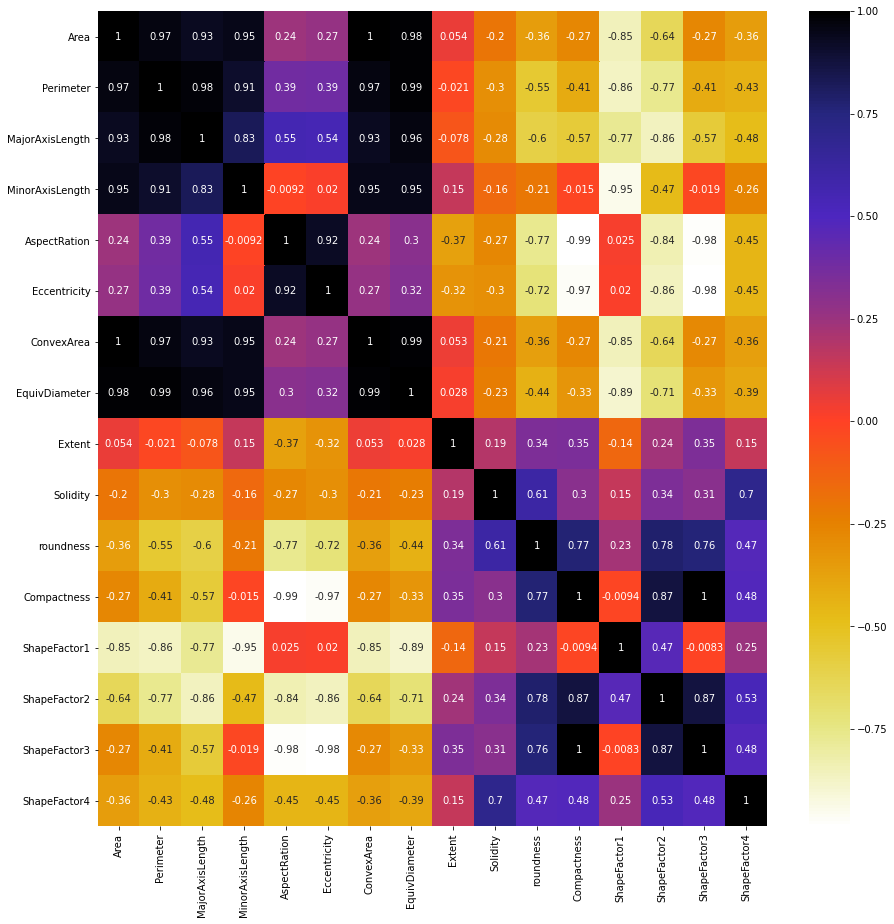

In [13]:
plt.figure(figsize=(15, 15))
cor = df_pandas.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [14]:
'''
 https://www.youtube.com/watch?v=FndwYNcVe0U
'''
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

The correlation function remove high correlation features, it helps to reduce dimension.

In [15]:
corr_features = correlation(df_pandas, 0.9)
print(corr_features)
df = df_pandas.drop(corr_features, axis=1)

{'ConvexArea', 'Perimeter', 'MinorAxisLength', 'EquivDiameter', 'ShapeFactor3', 'MajorAxisLength', 'Eccentricity'}


In [16]:
df

,Area,AspectRation,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor4,Class
0,28395.0,1.197191,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.998724,SEKER
1,28734.0,1.097356,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.998430,SEKER
2,29380.0,1.209713,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.999066,SEKER
3,30008.0,1.153638,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.994199,SEKER
4,30140.0,1.060798,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...
13606,42097.0,1.552728,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.998385,DERMASON
13607,42101.0,1.476439,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.998219,DERMASON
13608,42139.0,1.472582,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.996767,DERMASON
13609,42147.0,1.489326,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.995222,DERMASON


In [17]:
raw_data = spark.createDataFrame(df)

In [18]:
print(raw_data.count(), len(raw_data.columns))

13611 10


In [19]:
raw_data.printSchema()

root
 |-- Area: double (nullable = true)
 |-- AspectRation: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Solidity: double (nullable = true)
 |-- roundness: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- ShapeFactor1: double (nullable = true)
 |-- ShapeFactor2: double (nullable = true)
 |-- ShapeFactor4: double (nullable = true)
 |-- Class: string (nullable = true)



In [20]:
raw_data.show()

+-------+------------+-----------+-----------+-----------+-----------+------------+------------+------------+-----+
|   Area|AspectRation|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor4|Class|
+-------+------------+-----------+-----------+-----------+-----------+------------+------------+------------+-----+
|28395.0| 1.197191424|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.998723889|SEKER|
|28734.0| 1.097356461|0.783968133|0.984985603|0.887033637|0.953860842| 0.006978659| 0.003563624| 0.998430331|SEKER|
|29380.0| 1.209712656|0.778113248|0.989558774|0.947849473|0.908774239| 0.007243912| 0.003047733| 0.999066137|SEKER|
|30008.0| 1.153638059|0.782681273|0.976695743|0.903936374|0.928328835| 0.007016729| 0.003214562| 0.994198849|SEKER|
|30140.0|  1.06079802|0.773098035| 0.99089325|0.984877069|0.970515523|  0.00669701| 0.003664972| 0.999166059|SEKER|
|30279.0| 1.171066849|0.775688485|0.989509804|0.943851783|0.923725952| 0

In [21]:
# https://github.com/ahmetalkilinc/DataScienceTutorials/blob/master/BBM469_Tutorial_8_Machine_Learning_with_Spark.ipynb
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

original_data = transData(raw_data)
original_data.show(4)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[28395.0,1.197191...|SEKER|
|[28734.0,1.097356...|SEKER|
|[29380.0,1.209712...|SEKER|
|[30008.0,1.153638...|SEKER|
+--------------------+-----+
only showing top 4 rows



label indexer is give a number for categorical features. We are only considiring numerical values.

In [22]:
label_indexer = StringIndexer(inputCol='label' , outputCol='indexedLabel').fit(original_data)
indexed_data = label_indexer.transform(original_data)
indexed_data.show(3)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|[28395.0,1.197191...|SEKER|         2.0|
|[28734.0,1.097356...|SEKER|         2.0|
|[29380.0,1.209712...|SEKER|         2.0|
+--------------------+-----+------------+
only showing top 3 rows



label converter is convert indexed prediction result to categorical values

In [23]:
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=label_indexer.labels)

Min max normalization

In [24]:
normalize_feature = MinMaxScaler(inputCol="features", outputCol="Normalized").fit(original_data)
normalized_data = normalize_feature.transform(indexed_data)
normalized_data = normalized_data.select('Normalized', 'label', 'indexedLabel')
normalized_data.show(3)

+--------------------+-----+------------+
|          Normalized|label|indexedLabel|
+--------------------+-----+------------+
|[0.03405267382875...|SEKER|         2.0|
|[0.03550017933696...|SEKER|         2.0|
|[0.03825855266528...|SEKER|         2.0|
+--------------------+-----+------------+
only showing top 3 rows



In [25]:
# Indexed Original Data without splitting
original_data = indexed_data
original_data.show(3)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|[28395.0,1.197191...|SEKER|         2.0|
|[28734.0,1.097356...|SEKER|         2.0|
|[29380.0,1.209712...|SEKER|         2.0|
+--------------------+-----+------------+
only showing top 3 rows



In [26]:
# Indexed Normalized Data without splitting
normalized_data.show(3)

+--------------------+-----+------------+
|          Normalized|label|indexedLabel|
+--------------------+-----+------------+
|[0.03405267382875...|SEKER|         2.0|
|[0.03550017933696...|SEKER|         2.0|
|[0.03825855266528...|SEKER|         2.0|
+--------------------+-----+------------+
only showing top 3 rows



## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>

* Kmeans

In clustering function is that the kmeans algorith is clustring data. To find best clustring k, I tested range of 2 to 10. The results are evaluated and putted in silhouette score

In [27]:

def clustering(data, featureCol):
  silhouette_score=[]
  evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                  featuresCol=featureCol,
                                  metricName='silhouette', 
                                  distanceMeasure='squaredEuclidean')
  for i in range(2,10):    
    kmeans = KMeans(featuresCol=featureCol, k=i)
    kmeans_pred = kmeans.fit(data).transform(data)
    score = evaluator.evaluate(kmeans_pred)
    silhouette_score.append(score)
  return silhouette_score

Plotting the silhoutte score results

In [28]:
def kmeans_results(silhouette_score):
  plt.plot(range(2,10), silhouette_score)
  plt.show()

The create_clustring_dataframe function is helping to plot the clustring result. I used PCA here. It helps to reduced features to 2 dimension. Therefore I can plot the clustring result

In [29]:
def create_clustring_dataframe(kmeans_pred, features, pca_features):
  vis_data = kmeans_pred.select('prediction', 'label')
  vis_data_p1 = vis_data.toPandas()
  pca = PCA(k=2, inputCol=features, outputCol=pca_features)
  pca_pred = pca.fit(kmeans_pred).transform(kmeans_pred)
  pca_data = pca_pred.withColumn("component", vector_to_array(pca_features)).select([F.col("component")[i] for i in range(2)])
  vis_data_p2 = pca_data.toPandas()
  kmeans_vis_data = pd.concat([vis_data_p1, vis_data_p2], axis=1)
  return kmeans_vis_data


In [30]:
def plot_cluster_result(data):
  plt.style.use("fivethirtyeight")
  plt.figure(figsize=(8, 8))

  scat = sns.scatterplot(
      "component[0]",
      "component[1]",
      s=100,
      data=data,
      hue="prediction",
      style="label",
      palette="Set2",
  )

  scat.set_title(
      "After Clustering results from haricot bean species Data"
  )
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
  plt.show()

Clustring with original data

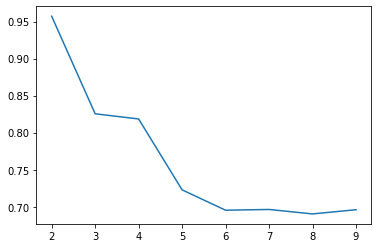

In [31]:
kmeans_results(clustering(original_data, 'features'))

In [32]:
best_k = 7
kmeans = KMeans(featuresCol='features', k=best_k)    
kmeans_pred = kmeans.fit(original_data).transform(original_data)
kmeans_pred.show(4)

+--------------------+-----+------------+----------+
|            features|label|indexedLabel|prediction|
+--------------------+-----+------------+----------+
|[28395.0,1.197191...|SEKER|         2.0|         5|
|[28734.0,1.097356...|SEKER|         2.0|         5|
|[29380.0,1.209712...|SEKER|         2.0|         5|
|[30008.0,1.153638...|SEKER|         2.0|         5|
+--------------------+-----+------------+----------+
only showing top 4 rows



Clustring with normalized data

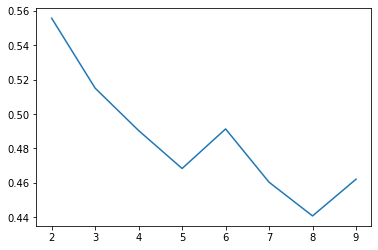

In [33]:
kmeans_results(clustering(normalized_data, 'Normalized'))

In [34]:
best_k = 7
kmeans = KMeans(featuresCol='Normalized', k=best_k)    
kmeans_pred_norm = kmeans.fit(normalized_data).transform(normalized_data)
kmeans_pred_norm.show(4)

+--------------------+-----+------------+----------+
|          Normalized|label|indexedLabel|prediction|
+--------------------+-----+------------+----------+
|[0.03405267382875...|SEKER|         2.0|         1|
|[0.03550017933696...|SEKER|         2.0|         1|
|[0.03825855266528...|SEKER|         2.0|         1|
|[0.04094006729406...|SEKER|         2.0|         1|
+--------------------+-----+------------+----------+
only showing top 4 rows



## Clustering results<a class="anchor" id="clustering"></a>

Original data clustring results

In [35]:
cluster_result = create_clustring_dataframe(kmeans_pred, 'features', 'pca_features')
cluster_result.head()

,prediction,label,component[0],component[1]
0,5,SEKER,-28395.000001,-0.629892
1,5,SEKER,-28734.000001,-0.534951
2,5,SEKER,-29380.000001,-0.641338
3,5,SEKER,-30008.000001,-0.589110
4,5,SEKER,-30140.000001,-0.477279


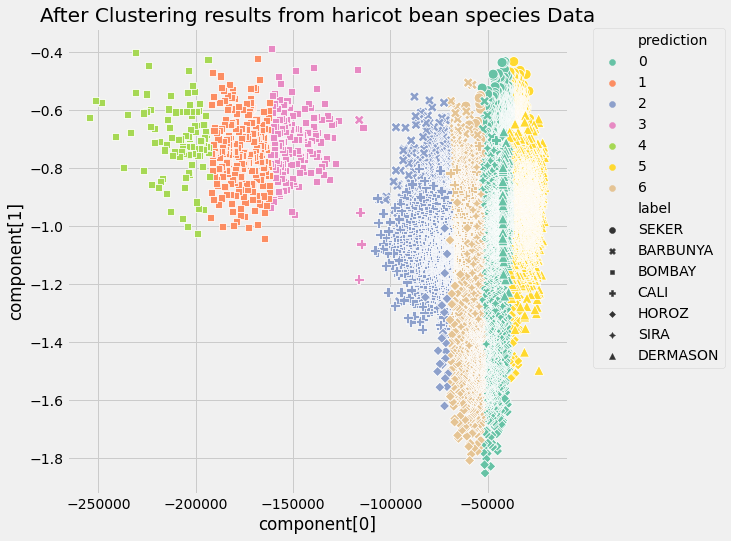

In [36]:
plot_cluster_result(cluster_result)

Normalized data clustring results

In [38]:
cluster_result = create_clustring_dataframe(kmeans_pred_norm, 'Normalized', 'pca_Normalized_features')
cluster_result.head()

,prediction,label,component[0],component[1]
0,1,SEKER,1.472173,-0.217481
1,1,SEKER,1.598759,-0.148479
2,1,SEKER,1.444977,-0.188847
3,1,SEKER,1.469191,-0.145131
4,1,SEKER,1.708602,-0.124144


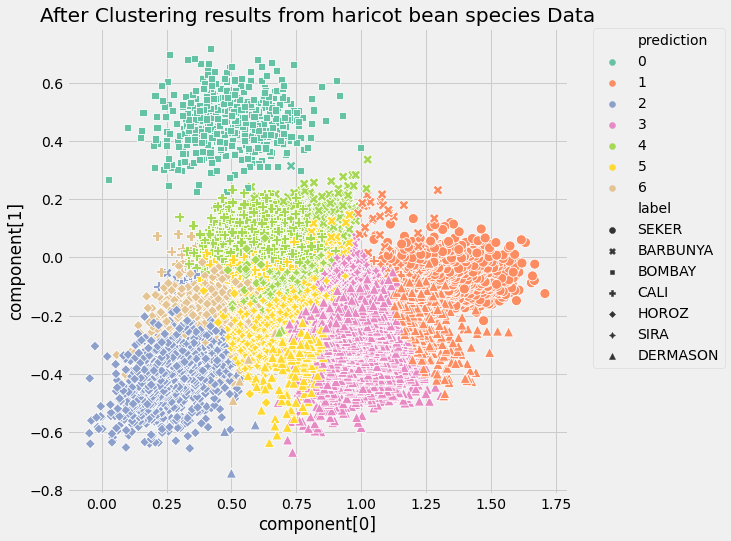

In [39]:
plot_cluster_result(cluster_result)

Depend on the clustring results, the clustring of the normalized data is better than original data.


## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

* Random forest classifier

First of all I split the original data with
* Training %80
* Testing %20

In [40]:
(X_train, X_test) = original_data.randomSplit([0.8, 0.2])

In [41]:
print(X_train.count())
X_train.show(3)

10835
+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|[28395.0,1.197191...|SEKER|         2.0|
|[29380.0,1.209712...|SEKER|         2.0|
|[30008.0,1.153638...|SEKER|         2.0|
+--------------------+-----+------------+
only showing top 3 rows



After the splitting data, I normalized them.

In [42]:
def normalization_for_classification(data):
  normalize_feature = MinMaxScaler(inputCol="features", outputCol="Normalized").fit(data)
  normalized_data = normalize_feature.transform(data)
  normalized_data = normalized_data.select('Normalized', 'label', 'indexedLabel')
  return normalized_data

In [43]:
normalized_X_train = normalization_for_classification(X_train)
normalized_X_test = normalization_for_classification(X_test)

print(normalized_X_train.count())
normalized_X_train.show(3)

10835
+--------------------+-----+------------+
|          Normalized|label|indexedLabel|
+--------------------+-----+------------+
|[0.03405267382875...|SEKER|         2.0|
|[0.03825855266528...|SEKER|         2.0|
|[0.04094006729406...|SEKER|         2.0|
+--------------------+-----+------------+
only showing top 3 rows



The classification function is that classified the data with given number of trees. To finding best number of trees, I create a for loop and to every distinct tree, I calculate accuracy and put them in acc_list with prediction dataframe.

In [44]:
def classification(train_data, test_data, featureCol):
  acc_list = [] # (accuracy,pred)
  for trees in range(1,21):
    # Train a RandomForest model.
    rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol=featureCol, numTrees=trees)
    model = rf.fit(train_data)
    pred = model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(
        labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(pred)
    pair = (accuracy, pred)
    acc_list.append(pair)
  return acc_list

In [45]:
acc_list_original_data = classification(X_train, X_test, 'features')
acc_list_normalized_data = classification(normalized_X_train, normalized_X_test, 'Normalized')


In [46]:
def plot_classification_results(acc_list):
  accuracies = [item[0] for item in acc_list]
  plt.plot(range(1,21), accuracies)
  plt.show()

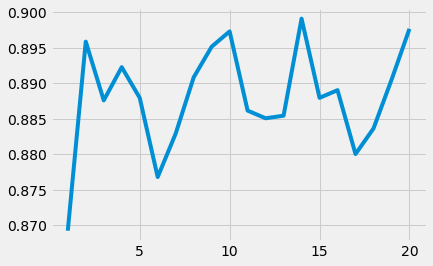

In [47]:
# Original data
plot_classification_results(acc_list_original_data)

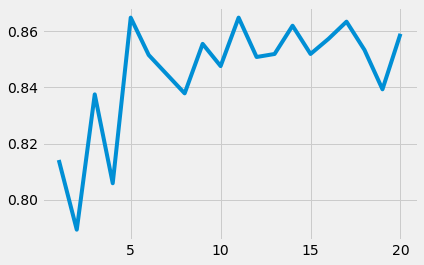

In [48]:
# Normalized data
plot_classification_results(acc_list_normalized_data)

Depend on the up above plots, I decided best number of trees.

**Note**: When you run again Randomfroset classifier the results can be different, you have to check up above plots and decide to best_epoch depend on this plots

In [49]:
# Original Data results
best_epoch = 13
best_accuracy = acc_list_original_data[best_epoch][0]

print("Test Error = %g " % (1.0 - best_accuracy))
print("The Best Accuracy = %g " % ( best_accuracy))
print()

od_pred = acc_list_original_data[best_epoch][1]
od_classification_pred = label_converter.transform(od_pred)
od_classification_pred.show()

Test Error = 0.100865 
The Best Accuracy = 0.899135 

+--------------------+-----+------------+--------------------+--------------------+----------+--------------+
|            features|label|indexedLabel|       rawPrediction|         probability|prediction|predictedLabel|
+--------------------+-----+------------+--------------------+--------------------+----------+--------------+
|[28734.0,1.097356...|SEKER|         2.0|[0.92925857646174...|[0.06637561260441...|       2.0|         SEKER|
|[30279.0,1.171066...|SEKER|         2.0|[1.54626463995105...|[0.11044747428221...|       2.0|         SEKER|
|[31107.0,1.160455...|SEKER|         2.0|[0.24883597528573...|[0.01777399823469...|       2.0|         SEKER|
|[31203.0,1.163315...|SEKER|         2.0|[0.24883597528573...|[0.01777399823469...|       2.0|         SEKER|
|[31335.0,1.177161...|SEKER|         2.0|[0.60932367394032...|[0.04352311956716...|       2.0|         SEKER|
|[31675.0,1.382815...|SEKER|         2.0|[13.2972087682561...|[0.9

In [57]:
# Normalized Data results
best_epoch = 4
best_accuracy = acc_list_normalized_data[best_epoch][0]

print("Test Error = %g " % (1.0 - best_accuracy))
print("The Best Accuracy = %g " % ( best_accuracy))
print()

nd_pred = acc_list_normalized_data[best_epoch][1]
nd_classification_pred = label_converter.transform(nd_pred)
nd_classification_pred.show()

Test Error = 0.135086 
The Best Accuracy = 0.864914 

+--------------------+-----+------------+--------------------+--------------------+----------+--------------+
|          Normalized|label|indexedLabel|       rawPrediction|         probability|prediction|predictedLabel|
+--------------------+-----+------------+--------------------+--------------------+----------+--------------+
|[0.03592304586705...|SEKER|         2.0|[2.92343981517047...|[0.58468796303409...|       0.0|      DERMASON|
|[0.04270304902666...|SEKER|         2.0|[2.88462401798235...|[0.57692480359647...|       0.0|      DERMASON|
|[0.04633660411802...|SEKER|         2.0|[2.00559175991783...|[0.40111835198356...|       2.0|         SEKER|
|[0.04675788586775...|SEKER|         2.0|[0.98988717587709...|[0.19797743517541...|       2.0|         SEKER|
|[0.04733714827362...|SEKER|         2.0|[0.98988717587709...|[0.19797743517541...|       2.0|         SEKER|
|[0.04882918780389...|SEKER|         2.0|[4.48792255752279...|[0.8

## Evaluation<a class="anchor" id="evaluation"></a>

In [58]:
def plot_confusion_matrix(matrix, title=None):
    '''https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
    '''

    # Get and reshape confusion matrix data
    # matrix = confusion_matrix(norm_y_test, predicted)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)

    # Add labels to the plot
    class_names = label_indexer.labels
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix for Random Forest Model ' + title)
    plt.show()

In [59]:
def prepare_cm(data):
  y_true = data.select("label")
  y_true = y_true.toPandas()

  y_pred = data.select("predictedLabel")
  y_pred = y_pred.toPandas()

  cm = confusion_matrix(y_true, y_pred)
  return cm

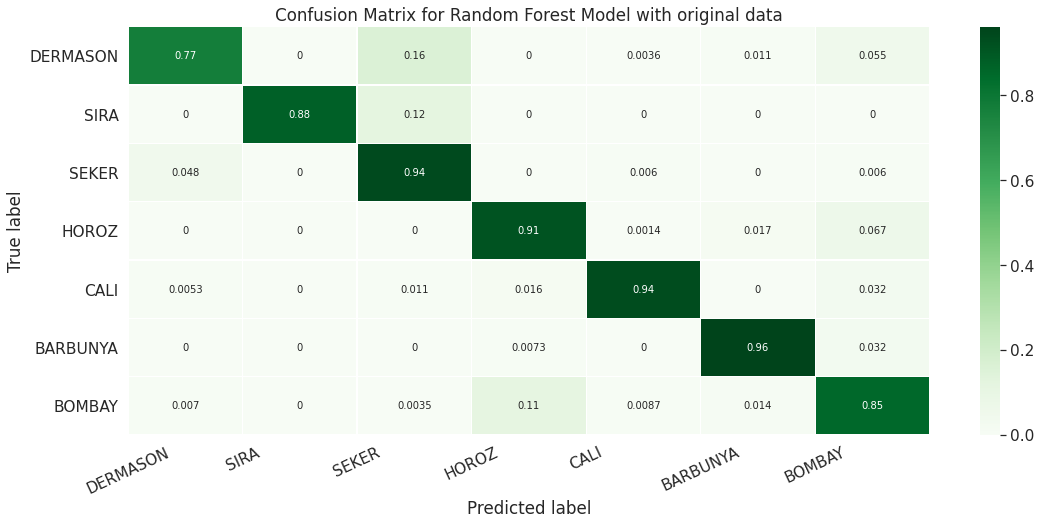

In [60]:
plot_confusion_matrix(prepare_cm(od_classification_pred),
                      title='with original data')

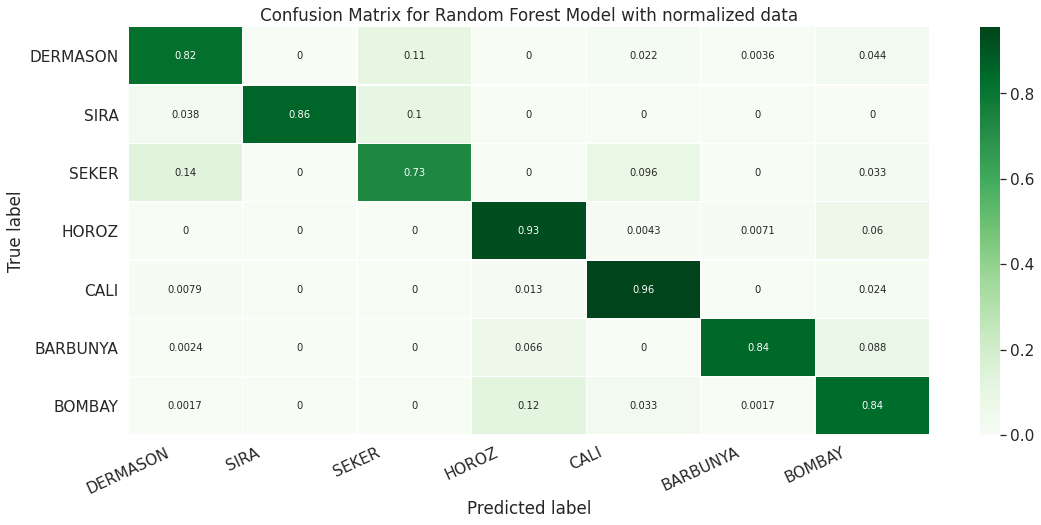

In [61]:
plot_confusion_matrix(prepare_cm(nd_classification_pred),
                      title='with normalized data')

Depend on the results the original data accuracy is higher than normalized data accuracy. The reason is that the random forest classification algorithm is doesn't need to normalization, the results can be same or lower. The more detailed explanation is here https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package

## References<a class="anchor" id="references"></a>

* https://github.com/ahmetalkilinc/DataScienceTutorials/blob/master/BBM469_Tutorial_8_Machine_Learning_with_Spark.ipynb
* https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package
* https://realpython.com/k-means-clustering-python/
* https://spark.apache.org/docs/latest/api/python/
* https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-regression
* https://spark.apache.org/docs/latest/mllib-clustering.html
* https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html

List all the sources you used during your work.
This includes jupyter notebooks you found on Internet.
Remeber, your work may not be an original one. However, this document must be genuine. Copy and paste kind of deliveries will be punished badly.


**Disclaimer!** <font color='grey'>This notebook was prepared by <student name(s)> as an assigment for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>